## Функция для расчета Retention Rate

Результатом должна быть функция, которая будет считать retention пользователей (по дням от даты регистрации пользователей) компании, которая занимается разработкой игр.

Для написания и отладки функции также прилагается набор данных**, необходимых для рассчета коэффициента.

Данные имеют следующую структуру:

**problem1-reg_data.csv** – данные о времени регистрации

- reg_ts - время регистрации
- uid - id пользователя


**problem1-auth_data.csv** – данные о времени захода пользователей в игру

- reg_ts - время авторизации (входа)
- uid - id пользователя

** Данные взяты из материалов курса **Karpov Courses** "Аналитик данных" 

**Импортируем необходимые для работы бибилиотеки**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# #Для статистических выводов
# import scipy.stats as stats
# from scipy.stats import levene
# from scipy.stats import chi2_contingency 

**Загрузим файлы и проведем разведочный анализ**

In [2]:
#Данные о времени регистрации
reg_data = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/sESwpymP4TytUg", sep=";")
#Данные о времени захода пользователей в игру
auth_data = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/b-HpkJU9Chlcbw", sep=";")

**Начнем с данных о регистрации**

In [3]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
# В таблице регистраций 1000000 строк и 2 столбца
# Столбец со временем регистрации в формате int64
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [5]:
#Нулевые значения отсутствуют
reg_data.isnull().sum()

reg_ts    0
uid       0
dtype: int64

In [6]:
#Повторяющиеся значения отсутствуют
reg_data.duplicated().sum()

0

In [7]:
#Оба столбца содержат уникальные значения - т.е. задвоении в зарегистрированных id нет
reg_data.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [8]:
#Приведем столбец со временем из числового к более классическому формату
#В аргументе unit укажем секунды (s)
reg_data['reg_ts'] = pd.to_datetime(reg_data.reg_ts, unit='s')
reg_data.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [9]:
#Теперь имеем привычный временной формат для дальнейших манипуляций с данными
reg_data.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

In [10]:
#Самая ранняя дата регистрации - 18/11/1998
reg_data.reg_ts.min()

Timestamp('1998-11-18 09:43:43')

In [11]:
#Самая поздняя дата регистрации - 23/09/2020
reg_data.reg_ts.max()

Timestamp('2020-09-23 15:17:24')

In [12]:
#Для наглядности создадим новый столбец с датой, где оставим только день, месяц и число
reg_data['reg_date'] = reg_data['reg_ts'].dt.normalize()

In [13]:
#Добавим еще один столбец с данными только по годам и посмотрим на кол-во регистраций в течение периода
reg_data['reg_year'] = reg_data['reg_date'].dt.to_period('Y')

<Axes: xlabel='reg_year'>

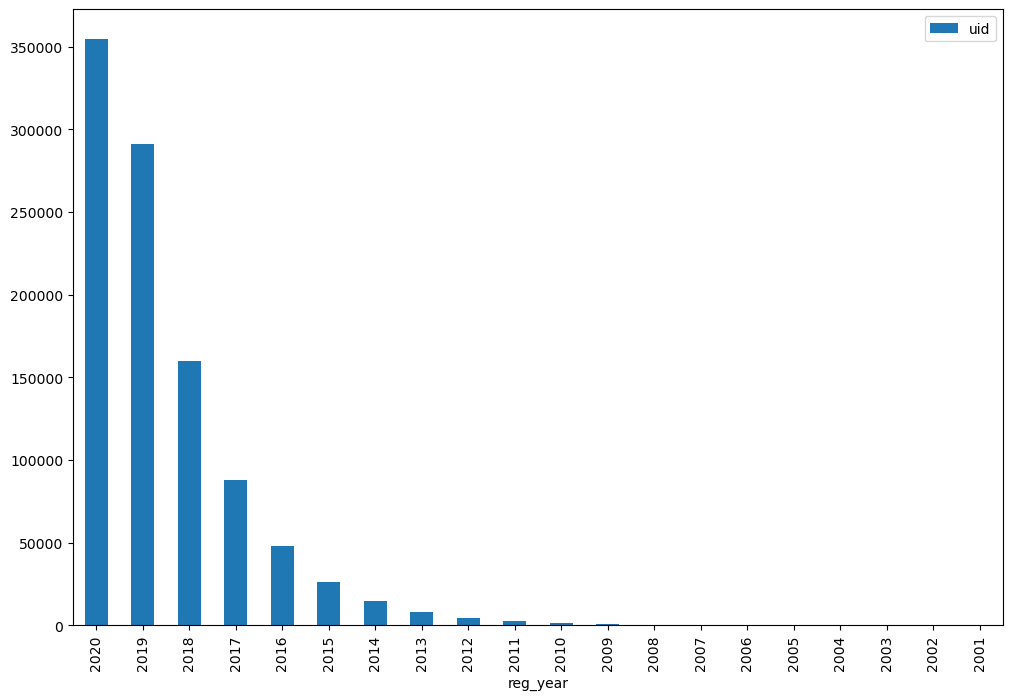

In [14]:
#Наблюдаем тенденцию по увеличению кол-ва регистраций от года к году
#Подобная картина выглядит вполне естественно с т.з. бизнеса
reg_data.groupby('reg_year').agg({'uid':'count'}).sort_values('uid', ascending=False).head(20).plot(kind='bar',figsize=(12,8))

**Перейдем к данным о заходах**

In [15]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [16]:
# В таблице заходов 9601013 строк и 2 столбца
# Столбец со временем также в формате int64
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [17]:
#Нулевые значения отсутствуют
auth_data.isnull().sum()

auth_ts    0
uid        0
dtype: int64

In [18]:
#Повторяющиеся значения отсутствуют
auth_data.duplicated().sum()

0

In [19]:
#Кол-во уникальных uid также составляет 1000000, как и в таблице с регистрацией. 
#Кол-во уникальных значений по датам входа меньше общего кол-ва (возможны повторяющееся время входа у пользователей)
auth_data.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [20]:
#Приведем столбец со временем из числового к более классическому формату
#В аргументе unit укажем секунды (s)
auth_data['auth_ts'] = pd.to_datetime(auth_data.auth_ts, unit='s')
auth_data.head()

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


In [21]:
#Теперь имеем привычный временной формат для дальнейших манипуляций с данными
auth_data.dtypes

auth_ts    datetime64[ns]
uid                 int64
dtype: object

In [22]:
#Самая ранняя дата входа - 18/11/1998
auth_data.auth_ts.min()

Timestamp('1998-11-18 09:43:43')

In [23]:
#Самая поздняя дата входа - 23/09/2020
auth_data.auth_ts.max()

Timestamp('2020-09-23 15:17:24')

In [24]:
#Также создадим новый столбец с датой, где оставим только день, месяц и число
auth_data['auth_date'] = auth_data['auth_ts'].dt.normalize()

In [25]:
#Добавим еще один столбец с данными только по годам и посмотрим на кол-во входов в течение периода
auth_data['auth_year'] = auth_data['auth_date'].dt.to_period('Y')

<Axes: xlabel='auth_year'>

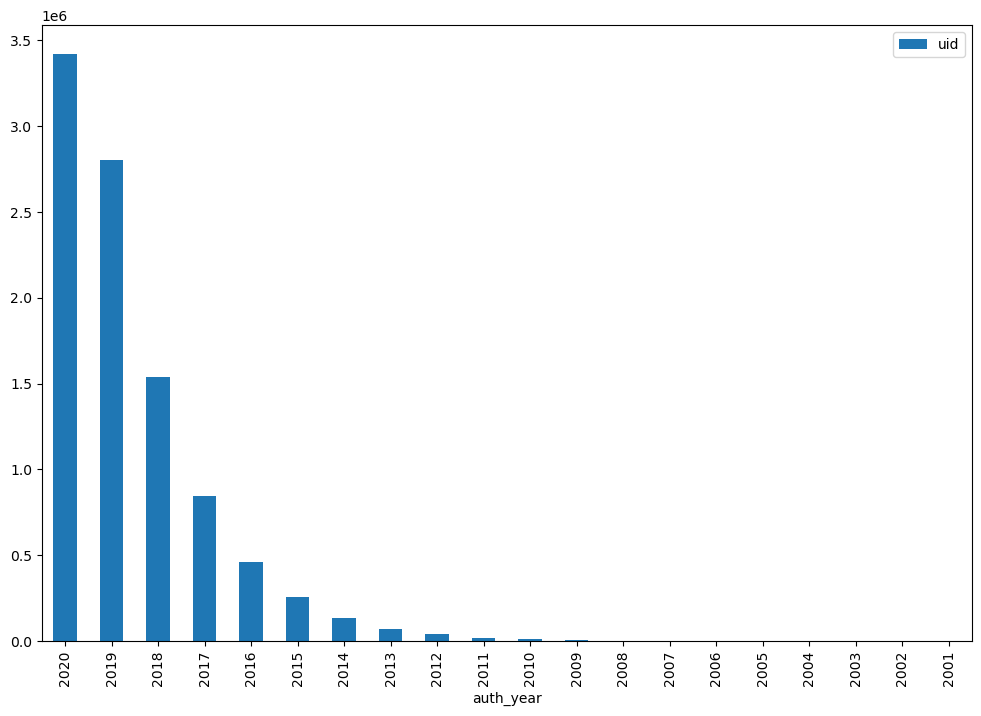

In [26]:
#Наблюдаем схожую тенденцию по увеличению кол-ва входов в приложение от года к году, что также вполне логично
auth_data.groupby('auth_year').agg({'uid':'count'}).sort_values('uid', ascending=False).head(20).plot(kind='bar',figsize=(12,8))

In [27]:
#Проверим, что uid в двух таблицах совпадают
auth_data['uid'].isin(reg_data['uid']).value_counts()

uid
True    9601013
Name: count, dtype: int64

In [28]:
#Объединим таблицы в одну и проверим на отсутствие таких записей по пользователям, 
#где значение даты и времени регистрации превышает дату и время входа
#Таких записей нет
complete_data = reg_data.merge(auth_data)
(complete_data['auth_ts'] < complete_data['reg_ts']).value_counts()

False    9601013
Name: count, dtype: int64

**По итогу:**

- В обоих датасетах отсутствуют нулевые значения;
- Повторяющиеся записи также отсутствуют;
- Столбцы с временными значениями приведены к удобному формату;
- Данные в датасетах не противоречат друг другу: 
    - Как пример: время самого раннего и последнего входов в приложение соответствуют времени регистрации;
    - С т.з. развития приложения также наблюдается естественная картина с постепенным увеличением кол-ва пользователей и их активности в приложении.

**Расчет Retention**

- Будем рассчитывать Retention n-го дня;
- Данные предоставлены за довольно большой период, для удобства попробуем сначала сделать расчет для первого месяца 2020;
- Retention rate для интервала будем считать как процент пользователей, которые оставались активными (заходили в приложение) на конкретную дату (интервал) относительно общего кол-ва пользователей, зарегистрировавшихся в определенный день;
- Будем делать расчет для каждого дня внутри установленного периода (для месяца ~ 30 дней, для квартала ~ 90 и т.д.).

In [29]:
reg_data = reg_data[['reg_ts','uid','reg_date']]

In [30]:
auth_data = auth_data[['auth_ts','uid','auth_date']]

In [31]:
#При целевом использовании функции Retention было бы удобно вводить даты старта и конца расчета.
#Это позволит получать срезы по разным временным отрезкам, а не только по календарным неделям, месяцам и годам
#Установим даты для Января 2020
first_date = '2020-01-01'
last_date = '2020-01-31'

In [32]:
#Объединим датасет с данными по регистрации с датасетом о входах по uid (регистрация - первое действие и так мы не потеряем пользователей)
full_data = reg_data.merge(auth_data, on = 'uid', how = 'left')
full_data.head()

,reg_ts,uid,reg_date,auth_ts,auth_date
0,1998-11-18 09:43:43,1,1998-11-18,1998-11-18 09:43:43,1998-11-18
1,1999-07-22 22:38:09,2,1999-07-22,1999-07-22 22:38:09,1999-07-22
2,1999-07-22 22:38:09,2,1999-07-22,1999-07-25 16:46:46,1999-07-25
3,1999-07-22 22:38:09,2,1999-07-22,1999-07-31 03:50:15,1999-07-31
4,1999-07-22 22:38:09,2,1999-07-22,1999-08-05 17:49:39,1999-08-05


In [33]:
#Отберем данные за Январь 2020 
select_data = full_data.loc[(full_data['reg_date'] >= first_date) & (full_data['auth_date'] <= last_date)].reset_index()
select_data.head()

,index,reg_ts,uid,reg_date,auth_ts,auth_date
0,8358767,2020-01-01 00:01:21,716362,2020-01-01,2020-01-01 00:01:21,2020-01-01
1,8358768,2020-01-01 00:02:42,716364,2020-01-01,2020-01-01 00:02:42,2020-01-01
2,8358769,2020-01-01 00:04:04,716365,2020-01-01,2020-01-01 00:04:04,2020-01-01
3,8358770,2020-01-01 00:05:25,716366,2020-01-01,2020-01-01 00:05:25,2020-01-01
4,8358771,2020-01-01 00:06:47,716367,2020-01-01,2020-01-01 00:06:47,2020-01-01


In [34]:
#Сгруппируем данные по дате регистрации и заходов по количеству uid
cohorts = select_data.groupby(['reg_date', 'auth_date'], as_index=False).agg({'uid':'nunique'})
cohorts.head()

,reg_date,auth_date,uid
0,2020-01-01,2020-01-01,1061
1,2020-01-01,2020-01-02,28
2,2020-01-01,2020-01-03,48
3,2020-01-01,2020-01-04,36
4,2020-01-01,2020-01-05,60


In [35]:
#Добавим столбец с кол-вом дней между входом и регистрацией (кол-во дней в приложении)
#Данный столбец будет представлять собой по сути когорты
cohorts['days_since_registration'] = (cohorts['auth_date'] - cohorts['reg_date']).dt.days
cohorts.head()

,reg_date,auth_date,uid,days_since_registration
0,2020-01-01,2020-01-01,1061,0
1,2020-01-01,2020-01-02,28,1
2,2020-01-01,2020-01-03,48,2
3,2020-01-01,2020-01-04,36,3
4,2020-01-01,2020-01-05,60,4


In [36]:
#Представим таблицу в виде, где в строке отображаются даты регистрации, в столбцах - кол-во дней в приложении. 
#В ячейках кол-во уникальных пользователей
rr_table = cohorts.pivot(index="reg_date", columns="days_since_registration", values="uid")
rr_table.head()

days_since_registration,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1061.0,28.0,48.0,36.0,60.0,62.0,80.0,53.0,47.0,47.0,...,47.0,37.0,29.0,40.0,33.0,42.0,38.0,35.0,35.0,25.0
2020-01-02,1063.0,25.0,48.0,55.0,51.0,62.0,82.0,63.0,60.0,56.0,...,42.0,46.0,44.0,36.0,40.0,36.0,33.0,36.0,33.0,NaN
2020-01-03,1065.0,25.0,36.0,47.0,48.0,73.0,80.0,58.0,48.0,45.0,...,47.0,40.0,33.0,34.0,40.0,38.0,27.0,26.0,NaN,NaN
2020-01-04,1067.0,16.0,48.0,54.0,57.0,61.0,75.0,58.0,45.0,52.0,...,25.0,38.0,34.0,34.0,28.0,27.0,29.0,NaN,NaN,NaN
2020-01-05,1069.0,21.0,48.0,49.0,47.0,51.0,84.0,56.0,42.0,58.0,...,47.0,36.0,41.0,37.0,40.0,34.0,NaN,NaN,NaN,NaN


In [37]:
#Для вычисления Retention Rate разделим значения в ячейках на данные из первого столбца (общее кол-во зарегистрированных пользователей для каждой когорты)
#Уберем первый столбец для итоговой таблицы (где RR - 100%)
retention_table = rr_table.div(rr_table[0], axis=0)
retention_table.index = retention_table.index.date
retention_table = retention_table.drop(columns=[0])
retention_table.head()

days_since_registration,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
2020-01-01,0.026390,0.045240,0.033930,0.056550,0.058435,0.075401,0.049953,0.044298,0.044298,0.053723,...,0.044298,0.034873,0.027333,0.037700,0.031103,0.039585,0.035815,0.032988,0.032988,0.023563
2020-01-02,0.023518,0.045155,0.051740,0.047977,0.058325,0.077140,0.059266,0.056444,0.052681,0.056444,...,0.039511,0.043274,0.041392,0.033866,0.037629,0.033866,0.031044,0.033866,0.031044,NaN
2020-01-03,0.023474,0.033803,0.044131,0.045070,0.068545,0.075117,0.054460,0.045070,0.042254,0.052582,...,0.044131,0.037559,0.030986,0.031925,0.037559,0.035681,0.025352,0.024413,NaN,NaN
2020-01-04,0.014995,0.044986,0.050609,0.053421,0.057170,0.070291,0.054358,0.042174,0.048735,0.047798,...,0.023430,0.035614,0.031865,0.031865,0.026242,0.025305,0.027179,NaN,NaN,NaN
2020-01-05,0.019645,0.044902,0.045837,0.043966,0.047708,0.078578,0.052385,0.039289,0.054256,0.041160,...,0.043966,0.033676,0.038354,0.034612,0.037418,0.031805,NaN,NaN,NaN,NaN


Text(3595.9274193548385, 0.5, 'Days')

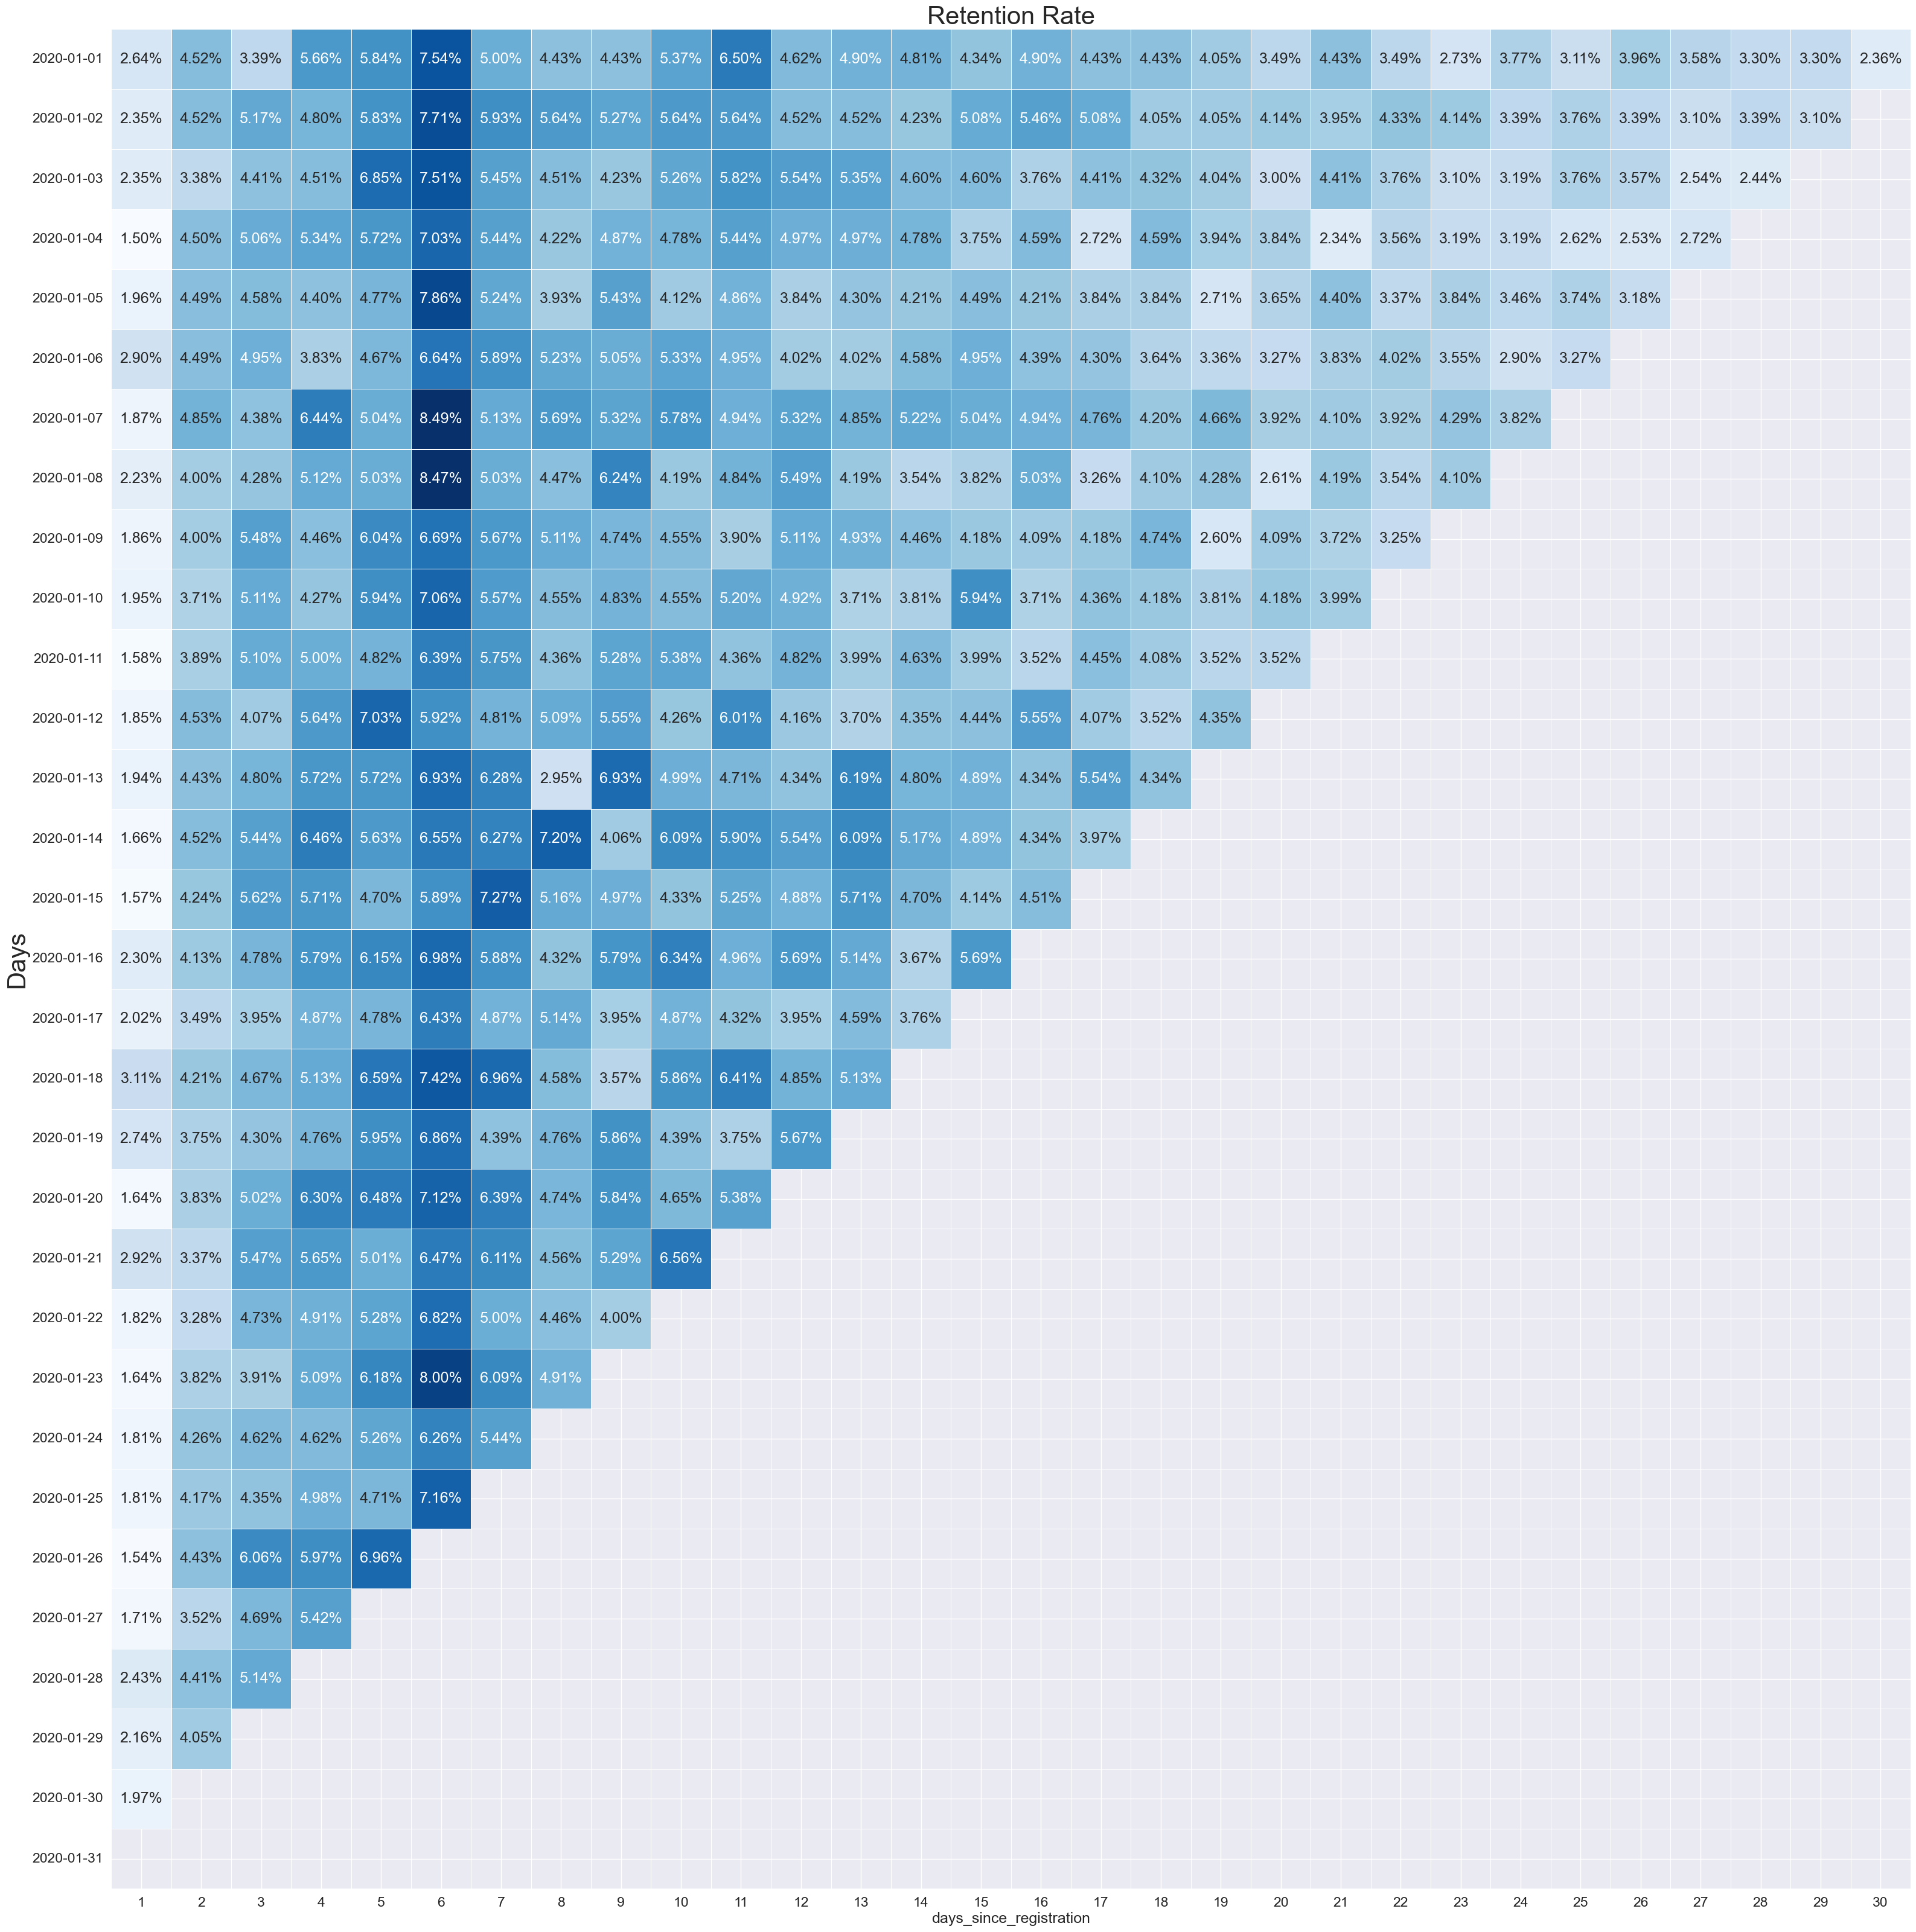

In [43]:
#Для более наглядного представления можно было бы использовать визуализацию - heatmap (тепловую карту)
sns.set(
        font_scale = 1.5,
        style = 'darkgrid',
        rc = {'figure.figsize': (100, 40)}
        )

ax = sns.heatmap(data = retention_table, 
                     cmap = 'Blues', 
                     annot = True,
                     fmt = '.2%',
                     cbar = False, 
                     linewidths = 0.5, 
                     square = True)
ax.set_title('Retention Rate', fontsize = 30)
ax.set_ylabel('Days', fontsize = 30)

**Подготовим функцию с учетом описанных выше шагов**

В кач-ве результата будем выводить графическое отображение таблицы (heatmap)

In [44]:
def retantion_rate(reg_data,auth_data,first_date,last_date):
    
    """Функция расcчитывает в табличной форме выводит показатель Retention за выбранный период.

    Аргументы функции:
    reg_data - Данные о регистрации пользователей (содержит uid и время регистрации)
    auth_data - Данные о входах пользователей (содержит uid и время захода)
    first_date - Дата, с которой необходимо начать расчет Retention
    last_date - Конечная дата для расчета Retention 
    
    Особенности: 
    Данные о регистрации и входах содержат время в числовом формате (int64), которые преобразовывются 
    в формат "yyyy-mm-dd"
    
    first_date и last_date задаются в формате "yyyy-mm-dd" (2020-01-01)
    
    """
    
    reg_data['reg_ts'] = pd.to_datetime(reg_data.reg_ts, unit='s').dt.normalize()
    auth_data['auth_ts'] = pd.to_datetime(auth_data.auth_ts, unit='s').dt.normalize()
    
    full_data = reg_data.merge(auth_data, how = 'left', on = 'uid')

    select_data = full_data.loc[(full_data['reg_ts'] >= first_date) & (full_data['auth_ts'] <= last_date)].reset_index()

    cohorts = select_data.groupby(['reg_ts', 'auth_ts'], as_index=False).agg({'uid':'nunique'})
    cohorts['days_since_registration'] = (cohorts['auth_ts'] - cohorts['reg_ts']).dt.days
        
    rr_table = cohorts.pivot(index="reg_ts", columns="days_since_registration", values="uid")

    retention_table = rr_table.div(rr_table[0], axis=0)
    retention_table.index = retention_table.index.date
    retention_table = retention_table.drop(columns=[0])
    
    ax = sns.heatmap(data = retention_table, 
                     cmap = 'Blues', 
                     annot = True,
                     fmt = '.2%',
                     cbar = False, 
                     linewidths = 0.5, 
                     square = True)
    ax.set_title('Retention Rate', fontsize = 30)
    ax.set_ylabel('Registration days', fontsize = 30)
    ax.set_xlabel('Days since registration', fontsize = 30)
    
    return ax

**Проверим работу функции с данными за Январь 2020**

In [45]:
reg_data = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/sESwpymP4TytUg", sep=";")
auth_data = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/b-HpkJU9Chlcbw", sep=";")

<Axes: title={'center': 'Retention Rate'}, xlabel='Days since registration', ylabel='Registration days'>

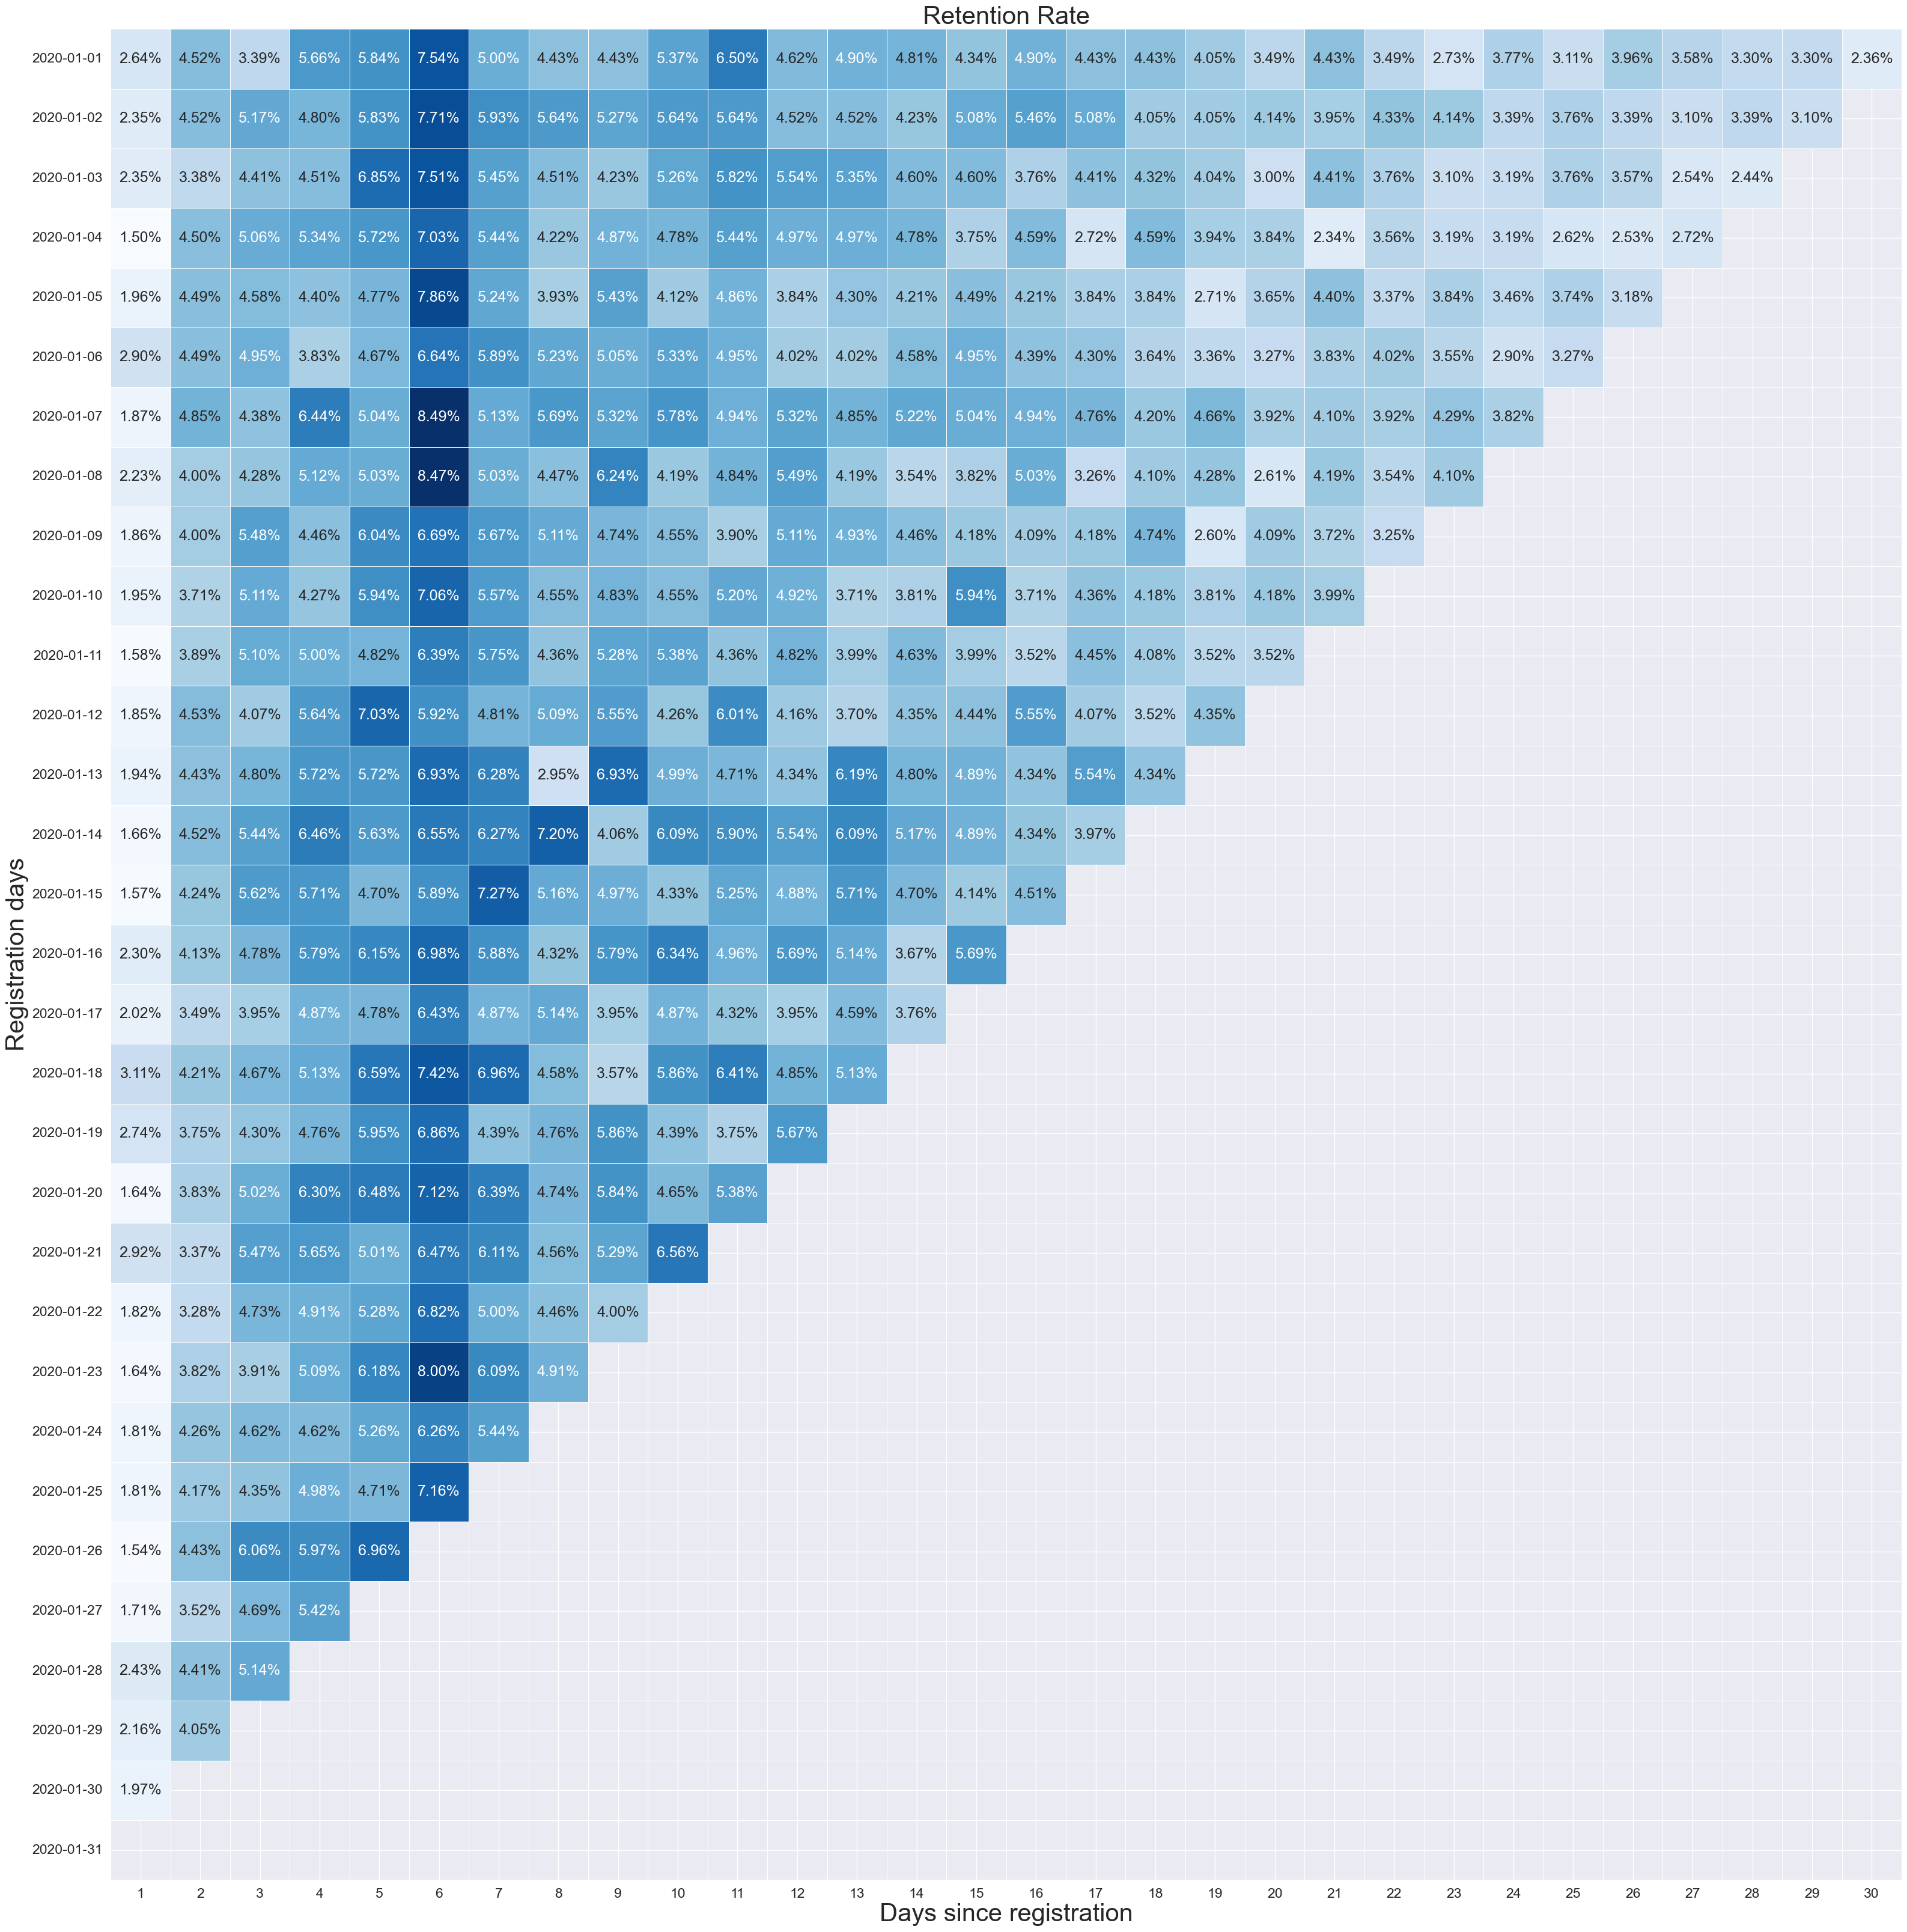

In [46]:
retantion_rate(reg_data, auth_data, '2020-01-01', '2020-01-31') 

## Итоги

**Функция выдает корректный результат**

Касаемо самих данных в первую очередь внимание на себя обращает тот факт, что наибольший процент пользователей наблюдается на 6 день после дня регистрации. 

Не имея достаточно вводных можно предположить, что это могло бы быть связано с механикой самой игры, которая каким-либо образом побуждает активно использовать приложение через данный промежуток времени

Примечание: 

Т.к. функция тестировалась на данных за месяц (~30 дней), настройка графика исходила из определенного кол-ва столбцов

Для более длительного периода необходимо скорректировать параметры для корректного отображения

(sns.set(
        font_scale = 1.5,
        style = 'darkgrid',
        rc = {'figure.figsize': (100, 40)}
        ))